# Basic cheminformatics with RDKit


In this notebook, we demonstrate the basic chem-informatics functionality of [RDKit](https://www.rdkit.org/), for those of you who are not familiar with this library. We show how to visually render molecules and reactions, starting from their representation formats, and how to do some basic analytics.

For more code examples check
* the RDKit cookbook [here](https://www.rdkit.org/docs/Cookbook.html) or
* the RDKit tutorial [here](https://www.rdkit.org/docs/GettingStartedInPython.html)

As a first step, we need to install RDKit, and all other supporing Python libraries. This notebook assumes using a Python3 interepreter (3.6+).

In [1]:
!pip install rdkit
!pip install numpy==1.19.5
!pip install pandas
!pip install jinja2

Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/


### 1) Display molecules

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.molSize = 400,400
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [3]:
# Visualize a kinase inhibitor
mol = Chem.MolFromSmiles("C1CC2=C3C(=CC=C2)C(=CN3C1)[C@H]4[C@@H](C(=O)NC4=O)C5=CNC6=CC=CC=C65")

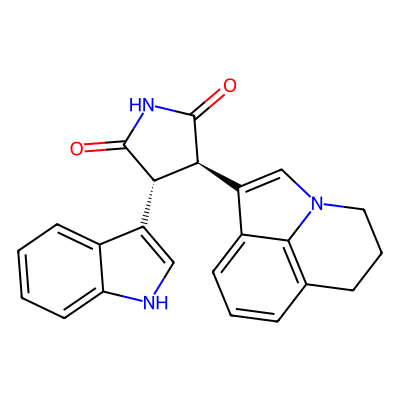

In [4]:
mol

In [5]:
def mol_with_atom_index(mol):
    '''
    Displays the constituent atoms
    and indexes them according to the order
    in which they are visited
    '''
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

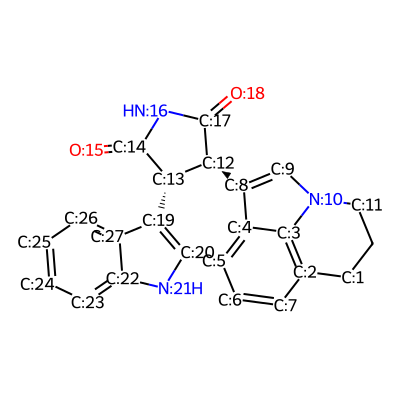

In [6]:
# With atom indexes
# Each number corresponds to the order in which each
# atom is vistited in the molecular graph
mol_with_atom_index(mol)

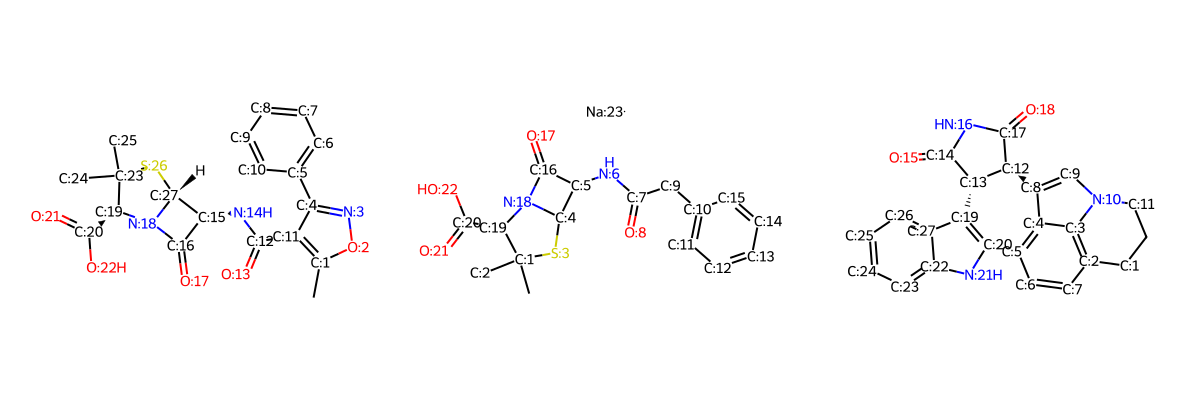

In [7]:
# Display a list of compounds horizontally, including the kinase inhibitor (last)
ms = [mol_with_atom_index(Chem.MolFromSmiles(x)) for 
      x in ('Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12',
            'CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O.[Na]')] + [mol]
Draw.MolsToGridImage(ms, subImgSize=(400, 400))

### 2) Do some basic analytics

In [8]:
from rdkit.Chem import Descriptors
import numpy as np

In [9]:
# Measure molecular weight, per molecule and as average
# The kinase inhibitor is the third score
for mol in ms:
    print('molecular weight:', Descriptors.MolWt(mol))
print('avg. molecular weight', np.mean([Descriptors.MolWt(mol) for mol in ms]))

molecular weight: 401.44400000000013
molecular weight: 357.38700000000006
molecular weight: 369.42400000000004
avg. molecular weight 376.08500000000004


In [10]:
# Detect aromatic rings
# Again, the third list corresponds to the kinase inhibitor
# Numbers correspond to atom indexes in the graphs
aromatic_carbon = Chem.MolFromSmarts("c")
for mol in ms:
    print(mol.GetSubstructMatches(aromatic_carbon))

((1,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,))
((10,), (11,), (12,), (13,), (14,), (15,))
((2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (19,), (20,), (22,), (23,), (24,), (25,), (26,), (27,))


### 3) Visualize reactions

In this example we use an extension of reaction-SMILES called SMARTS. We recall that the general syntax
of reaction schemes is:

$$
\text{reactant}_1 \cdot \text{reactant}_2 \cdot \dots \cdot \text{reactant}_n >> \text{product}_1 \cdot \text{product}_2 \cdot \dots \cdot \text{product}_m 
$$

Formulas are the counterpart of schemes over molecular graphs, where $\cdot$ (molecule composition) is replaced by $+$ and $>>$ by $\rightarrow$.

Reactions are **well-balanced** is the number of atoms to the left of $>>$ is equal to the number of atoms to the right!

In [11]:
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
from rdkit.Chem import rdChemReactions
from IPython.display import SVG

In [12]:
# Reaction rxn is from https://github.com/rdkit/UGM_2020/blob/master/Notebooks/Landrum_WhatsNew.ipynb
rxn = rdChemReactions.ReactionFromSmarts("[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[Cl].\
[cH:10]:1:[cH:11]:[cH:12](-[Cl:16]):[cH:13]:[cH:14]:[cH:15]:1-B(-O)-O>>\
[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[cH:15]:1[cH:10]:[cH:11]:[cH:12](-[Cl:16]):[cH:13]:[cH:14]:1")
drawer = rdMolDraw2D.MolDraw2DSVG(1200,300)
drawer.drawOptions().useBWAtomPalette()
drawer.DrawReaction(rxn)
drawer.FinishDrawing()

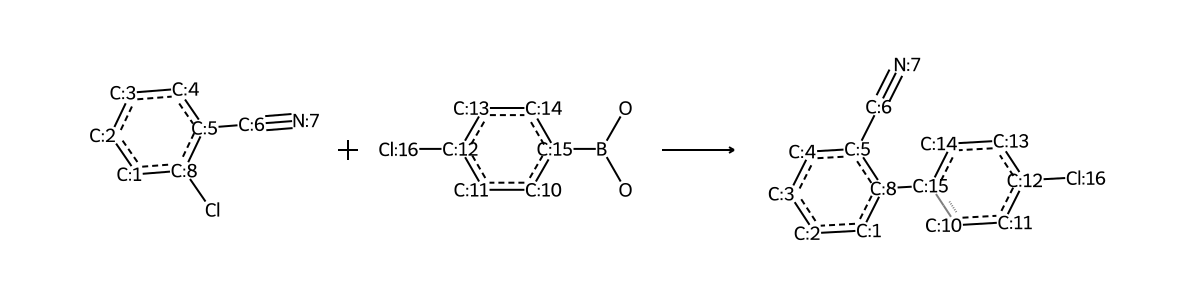

In [13]:
# Render
SVG(drawer.GetDrawingText())

In [14]:
# Determine if it is well balanced
r1 = "[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[Cl]"
r2 = "[cH:10]:1:[cH:11]:[cH:12](-[Cl:16]):[cH:13]:[cH:14]:[cH:15]:1-B(-O)-O"
pr = "[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[cH:15]:1[cH:10]:[cH:11]:[cH:12](-[Cl:16]):[cH:13]:[cH:14]:1"
w1 = Chem.MolFromSmarts(r1).GetNumAtoms()
w2 = Chem.MolFromSmarts(r2).GetNumAtoms()
w3 = Chem.MolFromSmarts(pr).GetNumAtoms()
print('Is', w1, '+', w2, '=' ,w3, '? ==>', ((w1 + w2) == w3)) # it is not!

Is 9 + 10 = 15 ? ==> False


### 4) Working with dataframes

In this section we see how to process entire batches of compounds: 
* read tabular data
* convert molecular description files into SMILES strings
* visualize the structures
* do some analytics

In [15]:
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Mol
#from IPython.display import display, Image
#from IPython.core.display import HTML

In [16]:
def disable_rdkit_logging():
    """
    Disables RDKit whiny logging
    """
    import rdkit.rdBase as rkrb
    import rdkit.RDLogger as rkl
    logger = rkl.logger()
    logger.setLevel(rkl.ERROR)
    rkrb.DisableLog('rdApp.error')

In [17]:
df = pd.read_csv('../datasets/rdkit/df_mol.tsv', sep='\t')

This table contains a number of compounds extracted using an OCR tool from illustrations in 
Engish language patents. Some are correct, others are not. It contains the following information:

* document name (`DocName`)
* molecular file (`SilverMolfile`)
* a unique UID (`SubstanceRegstring`), whenever a chemical normalized (ChemAxon) managed to successfully validate them and link them to a known compound
* a confidence score (`clide_conf`) from the OCR system (CLiDE) as to whether it is chemically valid or not

In [18]:
df.head()

,DocName,SilverMolfile,clide_conf,SubstanceRegstring
0,EP1744619B1,EP1744619B1_00003[image:1][structure:1]_; CLi...,0.9125,NaN
1,EP1744619B1,EP1744619B1_00004[image:1][structure:1]_; CLi...,0.7700,NaN
2,EP1744619B1,EP1744619B1_00005[image:1][structure:1]_; CLi...,0.9625,NaN
3,EP1744619B1,EP1744619B1_00006[image:1][structure:1]_; CLi...,0.9600,NaN
4,EP1744619B1,EP1744619B1_00007[image:1][structure:2]_; CLi...,1.0000,001F000060CD700000000000100055355355375534C953...


In [19]:
def mol2smiles(molstring): 
    '''
    Converts MOL files into SMILES
    '''
    smi = ''
    try:
        mol = Chem.MolFromMolBlock(molstring)
        smi = Chem.MolToSmiles(mol)
    except:
        pass
    return smi

In [20]:
disable_rdkit_logging() # disable logging!

In [21]:
# Convert to SMILES
df['smiles'] = df.SilverMolfile.apply(lambda x: mol2smiles(x.replace('_;','\n')))

In [22]:
df.head()

,DocName,SilverMolfile,clide_conf,SubstanceRegstring,smiles
0,EP1744619B1,EP1744619B1_00003[image:1][structure:1]_; CLi...,0.9125,NaN,CC.CCN(NC(=O)c1ccc(C)c(C)c1C)C(=O)C1=CC=CCC=C1
1,EP1744619B1,EP1744619B1_00004[image:1][structure:1]_; CLi...,0.7700,NaN,Cc1cc(C)cc(C(=O)N(C/C(=C2\CC2C)c2cccc(C)c2C)C(...
2,EP1744619B1,EP1744619B1_00005[image:1][structure:1]_; CLi...,0.9625,NaN,Cc1cc(C(=O)N(C)C)cc([Rb])c1C
3,EP1744619B1,EP1744619B1_00006[image:1][structure:1]_; CLi...,0.9600,NaN,CC(=O)N1c2ccc(C)cc2C(Nc2ccc(C)cc2)C[C@H]1C
4,EP1744619B1,EP1744619B1_00007[image:1][structure:2]_; CLi...,1.0000,001F000060CD700000000000100055355355375534C953...,Cc1c(Br)cccc1C(=O)O


In [24]:
# Render molecules
PandasTools.RenderImagesInAllDataFrames(images=True)
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

,smiles,ROMol,clide_conf
0,CC.CCN(NC(=O)c1ccc(C)c(C)c1C)C(=O)C1=CC=CCC=C1,,0.9125
1,Cc1cc(C)cc(C(=O)N(C/C(=C2\CC2C)c2cccc(C)c2C)C(...,,0.7700
2,Cc1cc(C(=O)N(C)C)cc([Rb])c1C,,0.9625

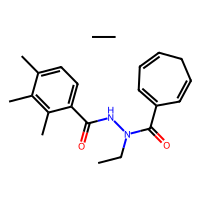
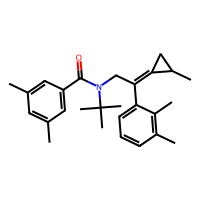
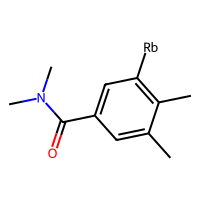

In [26]:
# Display
df[['smiles','ROMol','clide_conf']].head(3)

In [28]:
# Measure molecular weight for every row
df['weight'] = df.smiles.apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

,smiles,ROMol,clide_conf,weight
0,CC.CCN(NC(=O)c1ccc(C)c(C)c1C)C(=O)C1=CC=CCC=C1,,0.9125,354.494
1,Cc1cc(C)cc(C(=O)N(C/C(=C2\CC2C)c2cccc(C)c2C)C(...,,0.7700,389.583
2,Cc1cc(C(=O)N(C)C)cc([Rb])c1C,,0.9625,261.707

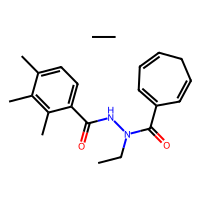
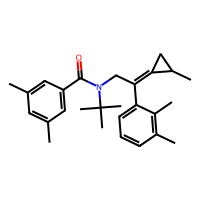
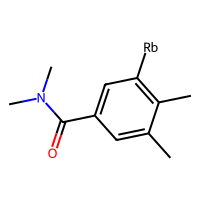

In [29]:
df[['smiles','ROMol','clide_conf', 'weight']].head(3)

### 5) Excercises

1. Determine if confidence correlates with molecular weight.
1. Visualize the weight distribution (possibly other characteristics as well) of the compounds as a bar plot.
1. Vectorize the compounds using e.g. Morgan fingerprints, and visualize them in 2D (you can use e.g. PCA to achieve this).